In [49]:
!pip install scikit-learn
!pip install tensorflow
!pip install -q kaggle
!pip install nltk
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import shutil

# Set source and destination for kaggle.json
source = "kaggle.json"
destination = os.path.expanduser("~/.kaggle/kaggle.json")

# Create .kaggle dir if it doesn't exist
os.makedirs(os.path.dirname(destination), exist_ok=True)

# Copy and set permissions
if not os.path.exists(destination):
    shutil.copy(source, destination)
    os.chmod(destination, 0o600)
    print("✅ kaggle.json configured.")
else:
    print("✅ kaggle.json already exists.")

✅ kaggle.json already exists.


In [3]:
!~/.local/bin/kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99%|██████████████████████████████████████▌| 1.02G/1.04G [00:01<00:00, 902MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:01<00:00, 903MB/s]


In [4]:
# Extract it
import zipfile
with zipfile.ZipFile("flickr8k.zip", 'r') as zip_ref:
    zip_ref.extractall("flickr8k")

print("✅ Dataset downloaded and extracted.")

✅ Dataset downloaded and extracted.


In [5]:
import pandas as pd
import os

# Paths
captions_path = "flickr8k/captions.txt"
images_dir = "flickr8k/Images"

# Read captions
df = pd.read_csv(captions_path)
df.columns = ['image', 'caption']

print("🖼️ Total images in folder:", len(os.listdir(images_dir)))
print("📝 Total captions:", len(df))
print("🖼️ Unique images with captions:", df['image'].apply(lambda x: x.split('#')[0]).nunique())

🖼️ Total images in folder: 8091
📝 Total captions: 40455
🖼️ Unique images with captions: 8091


In [6]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences


2025-06-29 03:44:25.120266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 03:44:25.126150: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 03:44:25.140285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751168665.162725  550598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751168665.169381  550598 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751168665.189857  550598 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [8]:
import string
from collections import defaultdict

def clean_captions(df):
    table = str.maketrans('', '', string.punctuation)
    captions_dict = defaultdict(list)

    for img, cap in zip(df['image'], df['caption']):
        img_id = img.split('#')[0]
        cap = cap.lower().translate(table)
        cap = ' '.join(word for word in cap.split() if word.isalpha())  # Remove non-words
        cap = f"startseq {cap} endseq"
        captions_dict[img_id].append(cap)

    return dict(captions_dict)

captions_dict = clean_captions(df)
print(f"✅ Captions cleaned for {len(captions_dict)} images.")


✅ Captions cleaned for 8091 images.


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

def build_tokenizer(captions_dict, threshold=5):
    all_captions = []
    word_counts = {}

    for caps in captions_dict.values():
        for cap in caps:
            all_captions.append(cap)
            for word in cap.split():
                word_counts[word] = word_counts.get(word, 0) + 1

    # Replace rare words with <unk>
    filtered = [
        ' '.join([w if word_counts[w] >= threshold else '<unk>' for w in cap.split()])
        for cap in all_captions
    ]

    tokenizer = Tokenizer(oov_token='<unk>')
    tokenizer.fit_on_texts(filtered)

    max_length = max(len(c.split()) for c in filtered)
    vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

    print(f"✅ Vocab size: {vocab_size}")
    print(f"✅ Max caption length: {max_length}")
    return tokenizer, vocab_size, max_length

tokenizer, vocab_size, max_length = build_tokenizer(captions_dict)


✅ Vocab size: 2989
✅ Max caption length: 37


In [10]:
# Save tokenizer to use later during model training and prediction
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved as tokenizer.pkl")


✅ Tokenizer saved as tokenizer.pkl


In [11]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print("✅ ResNet50 loaded.")

E0000 00:00:1751168669.071856  550598 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751168669.075786  550598 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ ResNet50 loaded.


In [12]:
def extract_features(img_dir, target_size=(224, 224), limit=None):
    features = {}
    image_list = sorted(os.listdir(img_dir))[:limit] if limit else os.listdir(img_dir)

    for img_name in tqdm(image_list, desc="🔍 Extracting image features"):
        img_path = os.path.join(img_dir, img_name)

        try:
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            feature_vector = resnet_model.predict(img_array, verbose=0)[0]
            features[img_name] = feature_vector
        except Exception as e:
            print(f"⚠️ Error processing {img_name}: {e}")
            continue

    return features

In [13]:
images_dir = "flickr8k/Images"  # or your actual image path
image_features = extract_features(images_dir)

🔍 Extracting image features: 100%|██████████| 8091/8091 [16:11<00:00,  8.33it/s]


In [14]:
np.savez_compressed("image_features.npz", **image_features)
print("✅ Saved extracted features to image_features.npz")

✅ Saved extracted features to image_features.npz


In [15]:
sample_key = next(iter(image_features))
print("🖼️ Sample image name:", sample_key)
print("🔢 Feature shape:", image_features[sample_key].shape)

🖼️ Sample image name: 502115726_927dd684d3.jpg
🔢 Feature shape: (2048,)


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import random

class DataGenerator(Sequence):
    def __init__(self, captions_dict, image_features, tokenizer, max_length, vocab_size, batch_size=32):
        self.captions_dict = captions_dict
        self.image_features = image_features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.samples = self._create_samples()
        print(f"✅ Generator initialized with {len(self.samples)} training samples.")

    def _create_samples(self):
        samples = []
        for img_id, captions in self.captions_dict.items():
            if img_id not in self.image_features:
                continue
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_word = seq[:i], seq[i]
                    samples.append((img_id, in_seq, out_word))
        random.shuffle(samples)
        return samples

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        X1, X2, y = [], [], []

        for img_id, in_seq, out_word in batch_samples:
            feature = self.image_features[img_id]
            X1.append(feature)
            X2.append(pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0])
            y.append(out_word)

        return (np.array(X1), np.array(X2)), np.array(y)

In [17]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

def build_caption_model(vocab_size, max_length):
    # Image input (from ResNet)
    inputs1 = Input(shape=(2048,))
    x1 = Dropout(0.5)(inputs1)
    x1 = Dense(256, activation='relu')(x1)

    # Text input (caption sequence)
    inputs2 = Input(shape=(max_length,))
    x2 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    x2 = Dropout(0.5)(x2)
    x2 = LSTM(256)(x2)

    # Combine image and text
    decoder = add([x1, x2])
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    model.summary()
    return model

caption_model = build_caption_model(vocab_size, max_length)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │    765,184 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 37, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 37)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2989)      │    768,173 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,649,005 (10.11 MB)

 Trainable params: 2,649,005 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import numpy as np

# Load pre-extracted image features
image_features = np.load("image_features.npz")
image_features = dict(image_features.items())

print(f"✅ Loaded features for {len(image_features)} images.")


✅ Loaded features for 8091 images.


In [19]:
from sklearn.model_selection import train_test_split

# Split keys into train and validation
all_keys = list(captions_dict.keys())
train_keys, val_keys = train_test_split(all_keys, test_size=0.2, random_state=42)

# Split captions_dict accordingly
train_captions = {k: captions_dict[k] for k in train_keys}
val_captions = {k: captions_dict[k] for k in val_keys}

# Create generators
train_gen = DataGenerator(train_captions, image_features, tokenizer, max_length, vocab_size, batch_size=32)
val_gen = DataGenerator(val_captions, image_features, tokenizer, max_length, vocab_size, batch_size=32)


✅ Generator initialized with 381576 training samples.
✅ Generator initialized with 95205 training samples.


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save only the best model
checkpoint = ModelCheckpoint('best_caption_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train!
caption_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint]
)


Epoch 1/20


/home/student/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.0439
Epoch 1: val_loss improved from inf to 3.28571, saving model to best_caption_model.h5


11925/11925 ━━━━━━━━━━━━━━━━━━━━ 880s 74ms/step - loss: 4.0439 - val_loss: 3.2857
Epoch 2/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.1216
Epoch 2: val_loss improved from 3.28571 to 3.20575, saving model to best_caption_model.h5


11925/11925 ━━━━━━━━━━━━━━━━━━━━ 885s 74ms/step - loss: 3.1216 - val_loss: 3.2057
Epoch 3/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.9726
Epoch 3: val_loss improved from 3.20575 to 3.19336, saving model to best_caption_model.h5


11925/11925 ━━━━━━━━━━━━━━━━━━━━ 880s 74ms/step - loss: 2.9726 - val_loss: 3.1934
Epoch 4/20
11924/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.9125
Epoch 4: val_loss did not improve from 3.19336
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 865s 72ms/step - loss: 2.9125 - val_loss: 3.2196
Epoch 5/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.8772
Epoch 5: val_loss did not improve from 3.19336
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 868s 73ms/step - loss: 2.8772 - val_loss: 3.2079
Epoch 6/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.8664
Epoch 6: val_loss did not improve from 3.19336
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 876s 73ms/step - loss: 2.8664 - val_loss: 3.2388
Epoch 7/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.8558
Epoch 7: val_loss did not improve from 3.19336
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 866s 73ms/step - loss: 2.8558 - val_loss: 3.2589
Epoch 8/20
11925/11925 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.8654
Epoch 8: val_loss did not improve from 3.1

In [22]:
caption_model.load_weights('best_caption_model.h5')

In [23]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([np.array([photo_feature]), sequence], verbose=0)
        word = tokenizer.index_word.get(np.argmax(yhat), None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq', '').replace('endseq', '').strip()


In [29]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for img_id in val_keys[:100]:  # Evaluate on first 100 for speed
    if img_id not in image_features:
        continue

    photo_feature = image_features[img_id]
    pred_caption = generate_caption(caption_model, tokenizer, photo_feature, max_length).split()
    true_captions = [c.split() for c in captions_dict[img_id]]

    predicted.append(pred_caption)
    actual.append(true_captions)

In [30]:
# BLEU scores
print("✅ BLEU-1:", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("✅ BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("✅ BLEU-3:", corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("✅ BLEU-4:", corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


✅ BLEU-1: 0.46335504885993484
✅ BLEU-2: 0.2880567687317058
✅ BLEU-3: 0.1566238652805333
✅ BLEU-4: 0.08445837790000847


In [31]:
# Load ResNet50 (exclude final classification layer)
resnet_model = ResNet50(weights='imagenet')
resnet_model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
def extract_features_resnet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array, verbose=0)
    return features.flatten()


In [34]:
def generate_caption(model, tokenizer, photo_feature, max_length=34):
    in_text = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([np.array([photo_feature]), seq], verbose=0)
        next_word = tokenizer.index_word.get(np.argmax(yhat), None)
        if next_word is None or next_word == 'endseq':
            break
        in_text += ' ' + next_word
    return in_text.replace('startseq', '').replace('endseq', '').strip()


🖼️ Image: ./flickr8k/Images/3525417522_7beb617f8b.jpg
📝 Caption: a dog is running through the grass


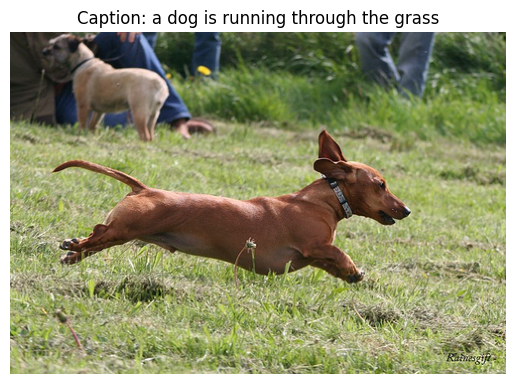

In [46]:
img_path = './flickr8k/Images/3525417522_7beb617f8b.jpg'
feature = extract_features_resnet(img_path)
caption = generate_caption(caption_model, tokenizer, feature)

# Print text caption
print("🖼️ Image:", img_path)
print("📝 Caption:", caption)

# Show the image with caption as title
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()


🖼️ Image: ./flickr8k/Images/110595925_f3395c8bd6.jpg
📝 Caption: a man in a red shirt is riding a bike on a dirt road


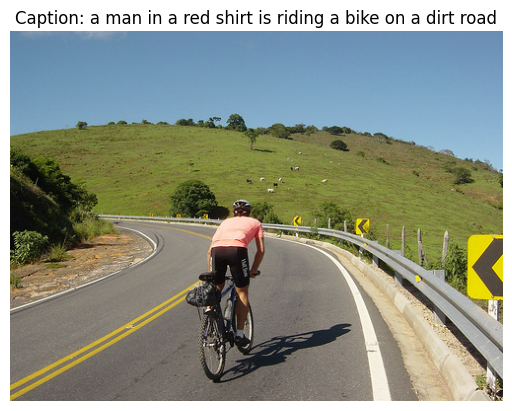

In [40]:
img_path = './flickr8k/Images/110595925_f3395c8bd6.jpg'
feature = extract_features_resnet(img_path)
caption = generate_caption(caption_model, tokenizer, feature)

# Print text caption
print("🖼️ Image:", img_path)
print("📝 Caption:", caption)

# Show the image with caption as title
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()


🖼️ Image: ./flickr8k/Images/111497985_38e9f88856.jpg
📝 Caption: a man in a red shirt is standing on a rock


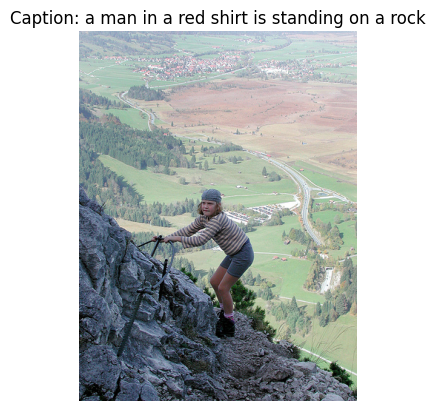

In [41]:
img_path = './flickr8k/Images/111497985_38e9f88856.jpg'
feature = extract_features_resnet(img_path)
caption = generate_caption(caption_model, tokenizer, feature)

# Print text caption
print("🖼️ Image:", img_path)
print("📝 Caption:", caption)

# Show the image with caption as title
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()


🖼️ Image: ./flickr8k/Images/90011335_cfdf9674c2.jpg
📝 Caption: a man is jumping off of a rock face


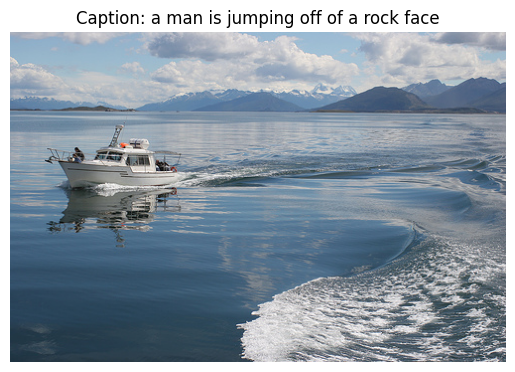

In [42]:
img_path = './flickr8k/Images/90011335_cfdf9674c2.jpg'
feature = extract_features_resnet(img_path)
caption = generate_caption(caption_model, tokenizer, feature)

# Print text caption
print("🖼️ Image:", img_path)
print("📝 Caption:", caption)

# Show the image with caption as title
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()


🖼️ Image: ./flickr8k/Images/3665569615_9a71c4b6e4.jpg
📝 Caption: a man in a red uniform is playing soccer


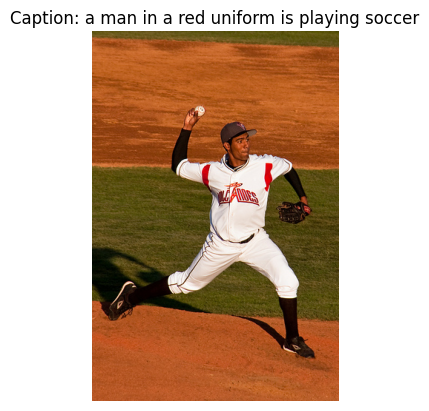

In [45]:
img_path = './flickr8k/Images/3665569615_9a71c4b6e4.jpg'
feature = extract_features_resnet(img_path)
caption = generate_caption(caption_model, tokenizer, feature)

# Print text caption
print("🖼️ Image:", img_path)
print("📝 Caption:", caption)

# Show the image with caption as title
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Caption: {caption}", fontsize=12)
plt.show()
